# One-Class Deep SVDD

From Ruff 2018

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow.random import normal
import tensorflow.keras as keras

from tensorflow.keras import Model, layers
from tensorflow.keras.datasets import mnist

print(tf.__version__)

from uad.MNIST.draw_line import set_anomaly, predict_anomalies, contour_anomalies, plot_anomalies, plot_predictions

# !nvidia-smi

2.2.0


In [2]:
(x_train, _), (x_test, _) = mnist.load_data()

x_train = np.expand_dims(x_train, -1).astype('float32') / 255.0
x_test = np.expand_dims(x_test, -1).astype('float32') / 255.0
    
print(x_train.shape, x_test.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1)


In [4]:
from uad.models.variational_autoencoder import SVDD_VAE, Sampling, conv2d_block

In [4]:
original_dim = 784
intermediate_dim = 64
kernel_size = 3
dropout = 0.2
batchnorm = False
n_filters = 16
latent_dim = n_filters * 1
latent_side = 4

# Define encoder model.
encoder_inputs = tf.keras.Input(shape=(28, 28, 1), name="encoder_inputs")

paddings = tf.constant([[0, 0], [2, 2], [2, 2], [0,
                                                 0]])  # shape d x 2 where d is the rank of the tensor and 2 represents "before" and "after"
x = tf.pad(encoder_inputs, paddings, name="pad")

# contracting path
x = conv2d_block(x, n_filters * 1, kernel_size=kernel_size, batchnorm=batchnorm)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(dropout)(x)

x = conv2d_block(x, n_filters * 2, kernel_size=kernel_size, batchnorm=batchnorm)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(dropout)(x)

x = conv2d_block(x, n_filters=n_filters * 4, kernel_size=kernel_size, batchnorm=batchnorm)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(dropout)(x)

z_mean = layers.Conv2D(latent_dim, 1, strides=1, name="z_mean")(x)
z_log_var = layers.Conv2D(latent_dim, 1, strides=1, name="z_log_var")(x)
z = Sampling()((z_mean, z_log_var))

encoder = tf.keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

# Define decoder model.
latent_inputs = tf.keras.Input(shape=(latent_side, latent_side, latent_dim), name="z_sampling")

x = layers.Conv2DTranspose(n_filters * 4, (kernel_size, kernel_size), input_shape=(latent_side, latent_side, 1),
                           strides=(2, 2), padding='same', name="u6")(latent_inputs)
x = layers.Dropout(dropout)(x)
x = conv2d_block(x, n_filters * 4, kernel_size=kernel_size, batchnorm=batchnorm)

x = layers.Conv2DTranspose(n_filters * 2, (kernel_size, kernel_size), strides=(2, 2), padding='same', name="u7")(x)
x = layers.Dropout(dropout)(x)
x = conv2d_block(x, n_filters * 2, kernel_size=kernel_size, batchnorm=batchnorm)

x = layers.Conv2DTranspose(n_filters * 1, (kernel_size, kernel_size), strides=(2, 2), padding='same', name="u8")(x)
x = layers.Dropout(dropout)(x)
decoder_outputs = conv2d_block(x, 1, kernel_size=kernel_size, batchnorm=batchnorm, activation1=True,
                               activation2=True)
crop = tf.image.resize_with_crop_or_pad(decoder_outputs, 28, 28)

decoder = tf.keras.Model(inputs=latent_inputs, outputs=crop, name="decoder")

oc_vae = SVDD_VAE(encoder, decoder, LAMBDA=1e-3)

oc_vae.compile(optimizer=tf.keras.optimizers.Adam())

In [8]:
oc_vae.fit(x_train, epochs=7, batch_size=128)

Epoch 1/7
469/469 [==============================] - 142s 303ms/step - loss: 129.7656 - reconstruction_loss: 125.2163 - svdd_loss: 4.5493
Epoch 2/7
469/469 [==============================] - 142s 304ms/step - loss: 109.7264 - reconstruction_loss: 105.7371 - svdd_loss: 3.9893
Epoch 3/7
469/469 [==============================] - 141s 302ms/step - loss: 99.0728 - reconstruction_loss: 95.6905 - svdd_loss: 3.3823
Epoch 4/7
469/469 [==============================] - 143s 306ms/step - loss: 92.4223 - reconstruction_loss: 89.3898 - svdd_loss: 3.0325
Epoch 5/7
469/469 [==============================] - 142s 303ms/step - loss: 87.6043 - reconstruction_loss: 84.8118 - svdd_loss: 2.7925
Epoch 6/7
469/469 [==============================] - 142s 303ms/step - loss: 84.3618 - reconstruction_loss: 81.7438 - svdd_loss: 2.6180
Epoch 7/7
469/469 [==============================] - 143s 304ms/step - loss: 81.7360 - reconstruction_loss: 79.2495 - svdd_loss: 2.4865


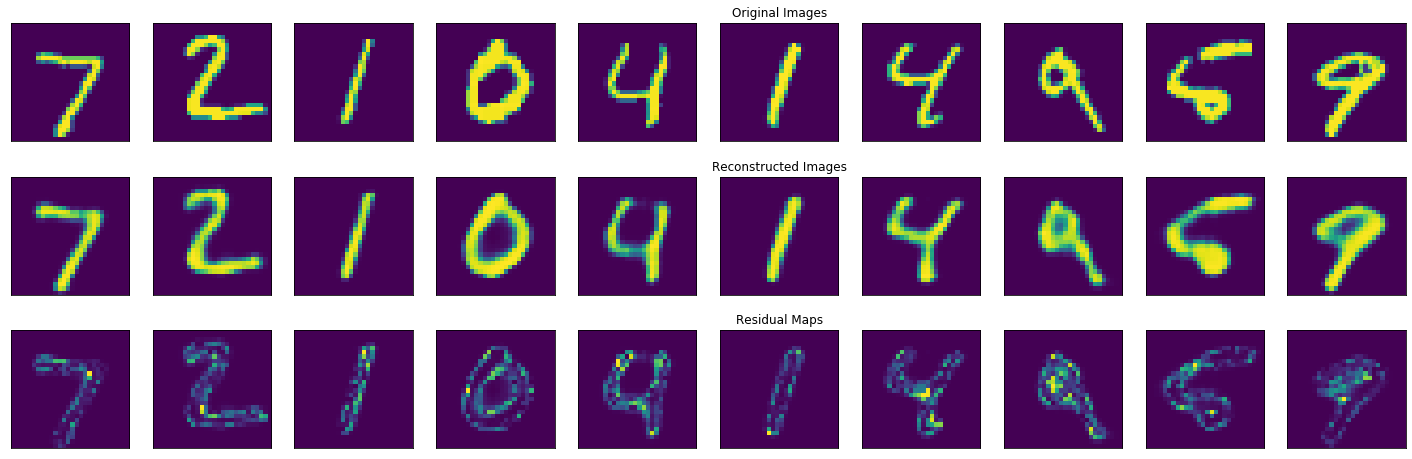

In [9]:
plot_predictions(oc_vae, x_test, 10, dims=(28, 28, 1))

In [ ]:
# dim (1, 1, 2) = 2 au total : plot dans graphique 2D avec couleurs=y_test